In [ ]:
import os
import torch
import torchvision.transforms as transforms
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple, List, Dict

In [12]:
class PascalVOCDataset(Dataset):
    """
    Pascal VOC Dataset for object localization.
    Each sample represents one bounding box (object instance).
    """
    
    def __init__(self, root_dir: str, year: str = '2012', split: str = 'train',
                 transform=None, include_difficult: bool = False):
        """
        Args:
            root_dir: Root directory containing VOCdevkit/
            year: Dataset year ('2007' or '2012')
            split: One of 'train', 'val', or 'trainval'
            transform: Optional transform to apply to images
            include_difficult: Whether to include objects marked as difficult
        """
        self.root_dir = root_dir
        self.year = year
        self.split = split
        self.transform = transform
        self.include_difficult = include_difficult
    
        self.voc_root = os.path.join(root_dir, f'VOC{year}_train_val')
        self.image_dir = os.path.join(self.voc_root, 'JPEGImages')
        self.annotation_dir = os.path.join(self.voc_root, 'Annotations')
        
        # Pascal VOC classes
        self.classes = [
            'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
            'bus', 'car', 'cat', 'chair', 'cow',
            'diningtable', 'dog', 'horse', 'motorbike', 'person',
            'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
        ]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Load image IDs from split file
        split_file = os.path.join(self.voc_root, 'ImageSets', 'Main', f'{split}.txt')
        with open(split_file, 'r') as f:
            self.image_ids = [line.strip() for line in f.readlines()]
        
        # Parse all annotations and create list of (image_id, bbox, label)
        self.samples = []
        self._parse_annotations()
        
        print(f"Loaded {len(self.samples)} object instances from {len(self.image_ids)} images")
    
    def _parse_annotations(self):
        """Parse all XML annotations and create sample list."""
        for image_id in self.image_ids:
            annotation_path = os.path.join(self.annotation_dir, f'{image_id}.xml')
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            
            # Get image dimensions
            size = root.find('size')
            img_width = int(size.find('width').text)
            img_height = int(size.find('height').text)
            
            # Parse all objects in the image
            for obj in root.findall('object'):
                difficult = int(obj.find('difficult').text)
                
                # Skip difficult objects if specified
                if difficult and not self.include_difficult:
                    continue
                
                # Get class label
                class_name = obj.find('name').text
                if class_name not in self.class_to_idx:
                    continue
                
                label = self.class_to_idx[class_name]
                
                # Get bounding box
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                
                # Store sample
                self.samples.append({
                    'image_id': image_id,
                    'bbox': [xmin, ymin, xmax, ymax],
                    'label': label,
                    'class_name': class_name,
                    'img_width': img_width,
                    'img_height': img_height
                })
    
    def __len__(self) -> int:
        """Return total number of object instances."""
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict]:
        """
        Returns:
            image: Cropped image tensor of shape (C, H, W)
            target: Dictionary with 'bbox', 'label', 'class_name', etc.
        """
        sample = self.samples[idx]
        
        # Load image
        image_path = os.path.join(self.image_dir, f"{sample['image_id']}.jpg")
        image = Image.open(image_path).convert('RGB')
        
        # Convert to tensor
        if self.transform:
            image = self.transform(image)
        else:
            # Default: convert to tensor
            image = transforms.ToTensor()(image)
        
        # Return full image and annotation
        target = {
            'bbox': torch.tensor(sample['bbox'], dtype=torch.float32),
            'label': torch.tensor(sample['label'], dtype=torch.long),
            'class_name': sample['class_name'],
            'image_id': sample['image_id']
        }
        
        return image, target
    
    def crop_to_bbox(self, image: torch.Tensor, bbox: List[int]) -> torch.Tensor:
        """
        Crop image tensor to bounding box.
        
        Args:
            image: Image tensor of shape (C, H, W)
            bbox: Bounding box as [xmin, ymin, xmax, ymax]
        
        Returns:
            Cropped image tensor of shape (C, bbox_height, bbox_width)
        """
        xmin, ymin, xmax, ymax = bbox
        
        # Ensure coordinates are within bounds
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        xmax = min(image.shape[2], xmax)
        ymax = min(image.shape[1], ymax)
        
        # Crop using tensor slicing: image[:, ymin:ymax, xmin:xmax]
        cropped = image[:, ymin:ymax, xmin:xmax]
        
        return cropped
    
    def get_cropped_object(self, idx: int) -> Tuple[torch.Tensor, Dict]:
        """
        Convenience method to get already-cropped object region.
        
        Returns:
            cropped_image: Cropped image tensor
            target: Dictionary with label and metadata
        """
        image, target = self.__getitem__(idx)
        bbox = target['bbox'].int().tolist()
        cropped_image = self.crop_to_bbox(image, bbox)
        
        return cropped_image, target

Loaded 27450 object instances from 11540 images
Total objects: 27450



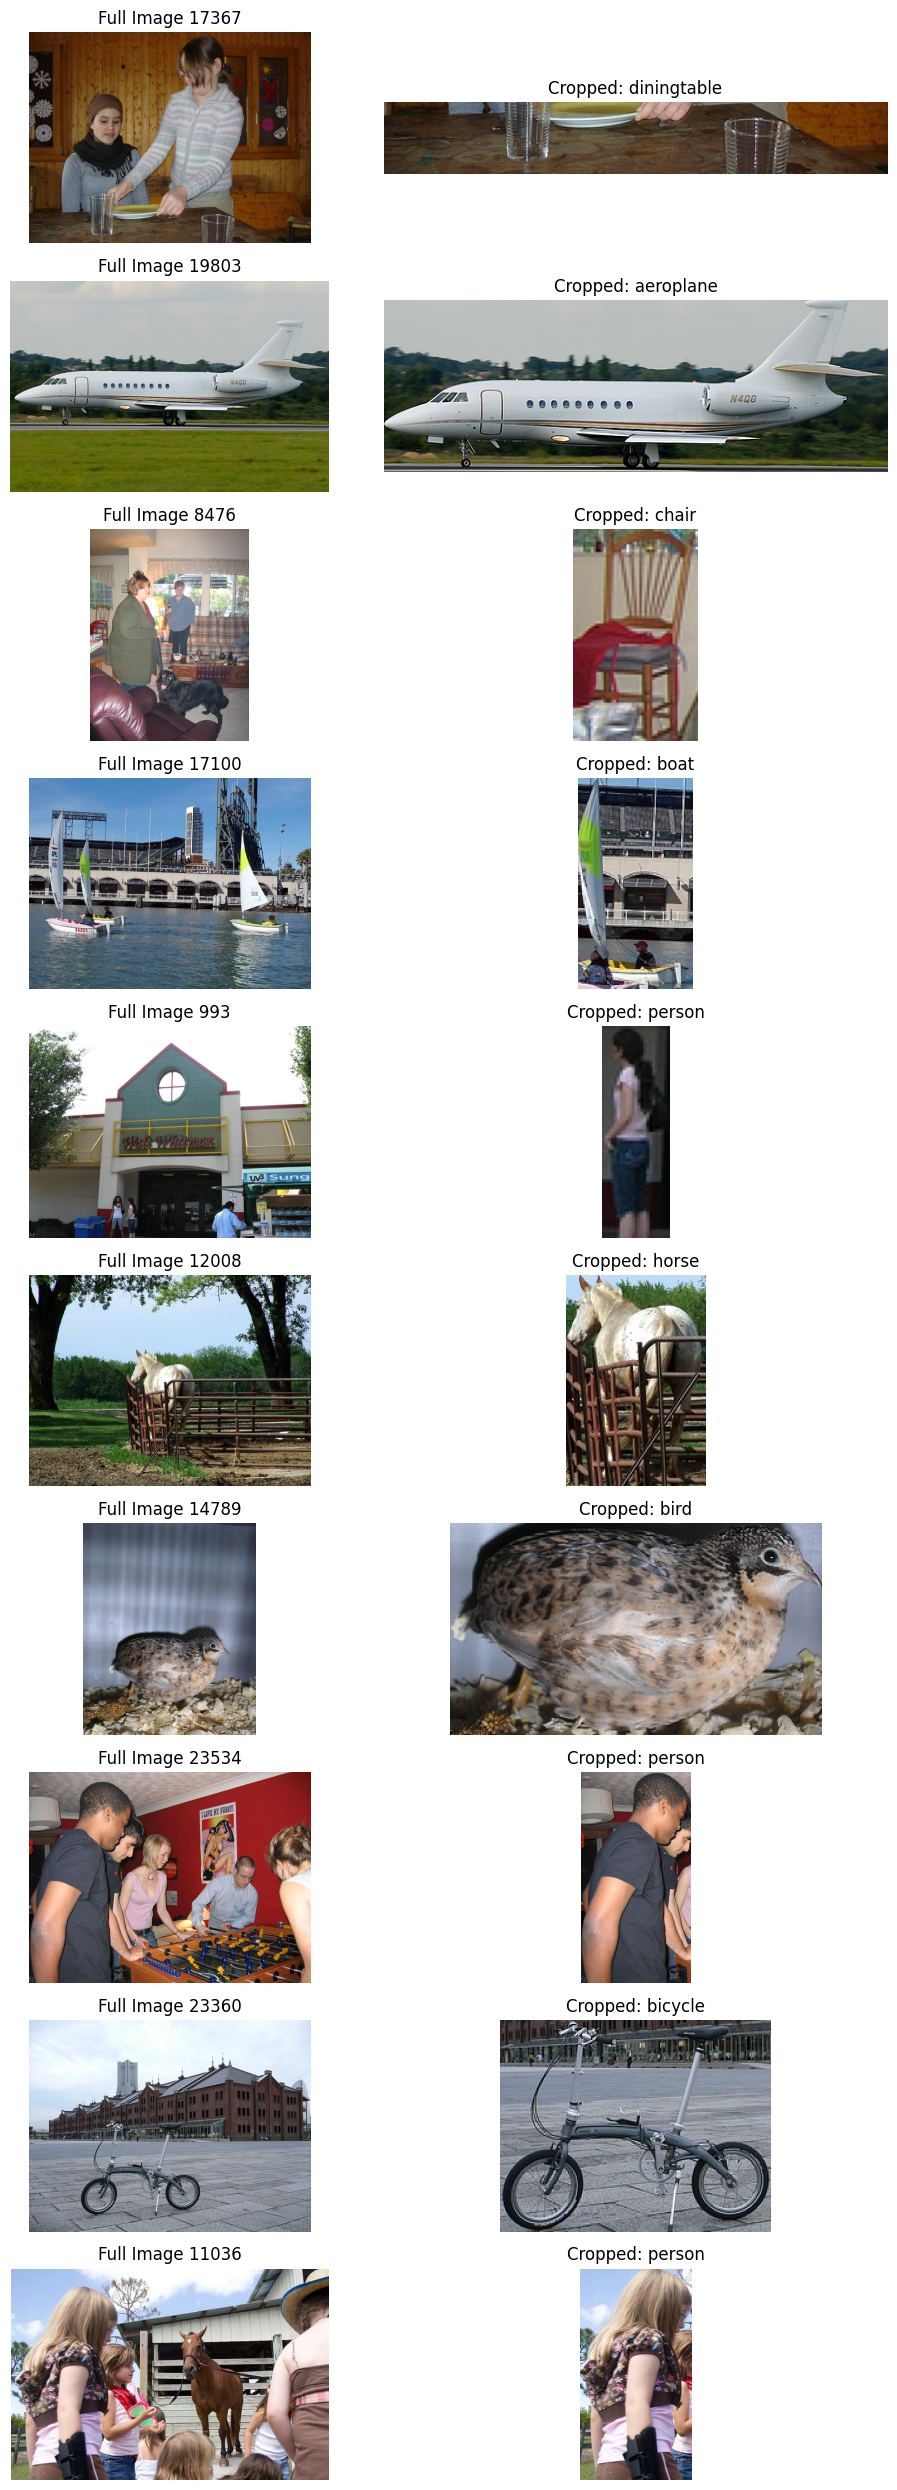

In [24]:
# Initialize the dataset
dataset = PascalVOCDataset(
    root_dir='../../data/VOC2012',
    year='2012',
    split='trainval'
)

print(f"Total objects: {len(dataset)}\n")

# Randomly pick 10 samples
import random
random_indices = random.sample(range(len(dataset)), 10)

# Create 10x2 grid of subplots
fig, axes = plt.subplots(10, 2, figsize=(10, 25))

for i, idx in enumerate(random_indices):
    # Get full image and cropped object
    full_image, target = dataset[idx]
    cropped_image, _ = dataset.get_cropped_object(idx)
    
    # Display full image
    full_img_display = full_image.permute(1, 2, 0).numpy()
    axes[i, 0].imshow(full_img_display)
    axes[i, 0].set_title(f"Full Image {idx}")
    axes[i, 0].axis('off')
    
    # Display cropped image
    cropped_img_display = cropped_image.permute(1, 2, 0).numpy()
    axes[i, 1].imshow(cropped_img_display)
    axes[i, 1].set_title(f"Cropped: {target['class_name']}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()